In [1]:
#Define pytorch libraries (test on pytorch 1.8)
import torchvision, time, os, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224), # Resize the image to 224*224
        transforms.CenterCrop(224), # Crop the image to 224*224
        transforms.RandomHorizontalFlip(), # flip horizontally 50% of the time - increases train set variability
        transforms.ToTensor(), # convert it to a PyTorch tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet models expect this norm
    ]),
    'val': transforms.Compose([ # Normalize the image for validation
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #
    ]),
}

In [3]:
# define Path to the dataset
#data_dir = '.'
data_dir = './crop'

In [4]:
# Create train and validation datasets and loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=10)for x in ['train', 'val']} # Load the data in batches
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} # Get the size of the dataset
class_names = image_datasets['train'].classes # Get the class names
print(class_names) # Print the class names
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set the device to GPU if available
print(device) # Print the device

['Negative', 'Positive', 'Undetectable']
cuda:0


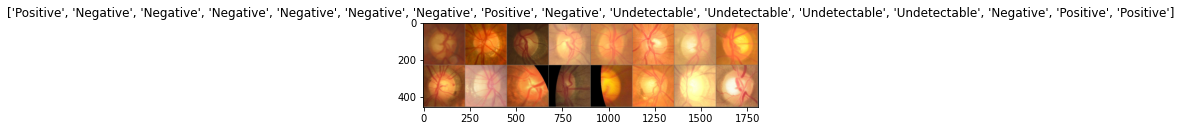

In [5]:
# Helper function for displaying images
def imshow(inp, title=None): 
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert to numpy
    mean = np.array([0.485, 0.456, 0.406]) # Get the mean of the image
    std = np.array([0.229, 0.224, 0.225]) # Get the standard deviation of the image
    
    # Un-normalize the images
    inp = std * inp + mean 
    # Clip just in case
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes]) #

In [6]:
# Define the model
# set number of epochs 25 as default if not specified
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # Get the time at the start of training

    best_model_wts = copy.deepcopy(model.state_dict()) # Copy the model weights
    best_acc = 0.0 # Set the best accuracy to 0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs): # Loop over the number of epochs
        epoch_start = time.time() # Get the time at the start of the epoch
        print('Epoch {}/{}'.format(epoch+1, num_epochs)) # Print the epoch number
        print('-' * 10) #

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train': 
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0 # Set the running loss to 0
            running_corrects = 0 # Set the running corrects to 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: # Loop over the data
                inputs = inputs.to(device) # Move the input to the GPU
                labels = labels.to(device)  # Move the labels to the GPU

                # zero the parameter gradients
                optimizer.zero_grad() # Set the gradients to 0

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'): # If we are in the training phase
                    outputs = model(inputs) # Get the output of the model
                    _, preds = torch.max(outputs, 1)    # Get the predictions
                    loss = criterion(outputs, labels)   # Calculate the loss

                    # backward + optimize only if in training phase
                    if phase == 'train': 
                        loss.backward() # Backpropagate the loss
                        optimizer.step() # Update the weights

                # Statistics
                running_loss += loss.item() * inputs.size(0) # Add the loss to the running loss
                running_corrects += torch.sum(preds == labels.data) # Add the corrects to the running corrects

            epoch_loss = running_loss / dataset_sizes[phase] # Calculate the epoch loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # Calculate the epoch accuracy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) # Print the epoch loss and accuracy

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc: # If we are in the validation phase and the accuracy is better than the best accuracy
                best_acc = epoch_acc # Set the best accuracy to the current accuracy
                best_model_wts = copy.deepcopy(model.state_dict())  # Copy the model weights
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start # Calculate the time taken for the epoch
        epoch_time.append(t_epoch) # Add the time to the list
        print() # Print a new line

    time_elapsed = time.time() - since # Calculate the time elapsed
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) # Print the time elapsed
    print('Best val Acc: {:4f}'.format(best_acc))   # Print the best accuracy

    # Load best model weights
    #model.load_state_dict(best_model_wts)
    return model, epoch_time # Return the model and the epoch time

In [7]:
#Checck the list of pretrained models in torchvision
#hhttps://pytorch.org/vision/stable/models.html
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [8]:
# Download a pre-trained ResNet18 model and freeze its weights
model = torchvision.models.resnet50(pretrained=True) # Load the pre-trained model
for param in model.parameters(): # Freeze the weights
    param.requires_grad = False # Set the gradients to False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features # Get the number of features of the model
model.fc = nn.Linear(num_ftrs, 3) # define the number of classes , 3 for the 3 classes
# Send the model to the GPU
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.00219, momentum=0.9) # Set the optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1) # Set the scheduler
model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=100) # Train the model

Epoch 1/100
----------


C:\Users\bahadur\.conda\envs\JetsonNano\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.0093 Acc: 0.5106
val Loss: 0.9398 Acc: 0.5408

Epoch 2/100
----------
train Loss: 0.9068 Acc: 0.5876
val Loss: 0.8997 Acc: 0.5999

Epoch 3/100
----------
train Loss: 0.9015 Acc: 0.5995
val Loss: 0.8326 Acc: 0.6370

Epoch 4/100
----------
train Loss: 0.9337 Acc: 0.5980
val Loss: 0.7909 Acc: 0.6533

Epoch 5/100
----------
train Loss: 0.8629 Acc: 0.6119
val Loss: 0.7663 Acc: 0.6614

Epoch 6/100
----------
train Loss: 0.8147 Acc: 0.6432
val Loss: 0.7200 Acc: 0.6792

Epoch 7/100
----------
train Loss: 0.8138 Acc: 0.6482
val Loss: 0.7449 Acc: 0.6757

Epoch 8/100
----------
train Loss: 0.8184 Acc: 0.6440
val Loss: 0.7832 Acc: 0.6606

Epoch 9/100
----------
train Loss: 0.8311 Acc: 0.6397
val Loss: 0.7375 Acc: 0.6660

Epoch 10/100
----------
train Loss: 0.8004 Acc: 0.6494
val Loss: 1.1275 Acc: 0.5748

Epoch 11/100
----------
train Loss: 0.8658 Acc: 0.6370
val Loss: 0.7862 Acc: 0.6571

Epoch 12/100
----------
train Loss: 0.8123 Acc: 0.6548
val Loss: 0.8434 Acc: 0.6146

Epoch 13/100

In [ ]:
print("Our model: \n\n", model, '\n') # Print the model
print("The state dict keys: \n\n", model.state_dict().keys()) # Print the state dict keys

In [ ]:
#torch.save(model.state_dict(), 'checkpoint.pth') 
#state_dict = torch.load('checkpoint.pth') 
#print(state_dict.keys())
#model.load_state_dict(state_dict)

In [9]:
torch.save(model, 'FUll_model_weight.pth') # Save the model

In [29]:
model = torch.load('FUll_model_weight.pth')     # Load the model
model.eval() # Set the model to evaluate mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# visualize the validation images
def visualize_model(model, num_images=6): # Function to visualize the model
    was_training = model.training 
    model.eval()
    images_so_far = 0 # Set the images so far to 0
    fig = plt.figure() # Create a figure

    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(dataloaders['val']): # Loop over the data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(labels)
            sm = nn.Softmax(dim=1)  # Create a softmax layer
            outputs = model(inputs)
            outputs = sm(outputs) # Apply the softmax function
            print(outputs)
            _, preds = torch.max(outputs, 1)
            
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far) # Plot the images
                ax.axis('off')  # Turn off the axis
                print(j) # Print the index
                print(class_names[preds[j]]) # Print the class name
                print(preds[j])     
                print(class_names)
                ax.set_title('predicted: {}'.format(class_names[preds[j]])) 
                imshow(inputs.cpu().data[j]) # Show the image

                if images_so_far == num_images:
                    model.train(mode=was_training) 
                    return
        model.train(mode=was_training)

tensor([[0.1823, 0.5199, 0.2978],
        [0.0233, 0.0067, 0.9701],
        [0.0489, 0.4280, 0.5231],
        [0.2677, 0.2393, 0.4930],
        [0.0628, 0.1131, 0.8241],
        [0.1514, 0.0490, 0.7995],
        [0.7098, 0.1383, 0.1520],
        [0.1052, 0.0314, 0.8634],
        [0.7876, 0.0245, 0.1879],
        [0.0053, 0.8769, 0.1178],
        [0.0432, 0.0262, 0.9306],
        [0.1380, 0.0182, 0.8438],
        [0.7842, 0.0662, 0.1496],
        [0.0148, 0.0147, 0.9704],
        [0.1854, 0.3382, 0.4764],
        [0.2773, 0.5429, 0.1797]], device='cuda:0')
0
Positive
tensor(1, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


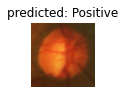

1
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


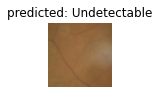

2
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


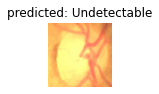

3
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


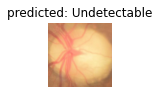

4
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


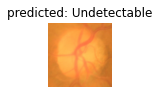

5
Undetectable
tensor(2, device='cuda:0')
['Negative', 'Positive', 'Undetectable']


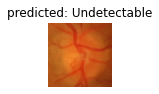

In [19]:
visualize_model(model) # Visualize the model

tensor([[0.2537, 0.5307, 0.2156]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(1, device='cuda:0')


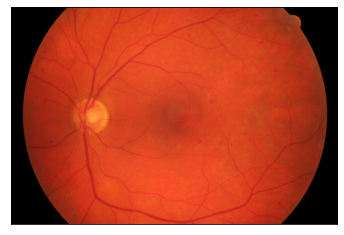

In [27]:
# Single image prediction
from PIL import Image
test_image = r'C:\Users\bahadur\Downloads\01_dr.JPG' # Set the path to the image
labels = ['Negative', 'Positive', 'Undetectable'] # Set the labels

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
#data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# Load the image
image_ = Image.open(test_image)
plt.imshow(image_), plt.xticks([]), plt.yticks([]) # Show the image

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image_).unsqueeze(0).cuda()
sm = nn.Softmax(dim=1)  # Create a softmax layer
out = model(image) # Apply the model to the image
out = sm(out) # Apply the softmax function
#preds = torch.max(outputs, 1)
print(out)
print(out.argmax())

In [28]:
print("Predicted class is: {}".format(labels[out.argmax()])) # Print the predicted class
confidence = out[0][out.argmax()] # Get the confidence of the prediction
print("* confidence: {:.4f}".format(confidence)) # Print the confidence

Predicted class is: Positive
* confidence: 0.5307
